## About Project

This project aims to build a classification model for sEMG (surface electromyography) signals to recognize hand gestures performed by individuals. The project involves the following steps:

- Data Acquisition: Collecting sEMG signals from 6 participants while performing 6 different hand gestures.

- Preprocessing: Filtering and cleaning the collected sEMG signals to remove any noise or unwanted artifacts.

- Feature Extraction: Extracting relevant features from the preprocessed sEMG signals to be used for classification.

- Classification: Developing and comparing different machine learning models for classifying the hand gestures based on the extracted features.

- Model Evaluation: Evaluating the performance of the developed models using metrics such as accuracy, precision, recall, and F1 score.

The goal of this project is to create a reliable and accurate classification model for sEMG signals that can be used in real-world applications such as prosthetic control, human-robot interaction, and virtual reality. The project will explore different outlier handling techniques and classification models to determine the best approach for achieving high accuracy in classifying the hand gestures.

## Importing Necessary Librarys

Various libraries are imported for different purposes, such as data handling and manipulation, signal processing, machine learning, data visualization, and statistical analysis.

In [1]:
import pandas as pd                # For data handling and manipulation
import os                          # For working with files and directories
import numpy as np                 # For numerical operations
from scipy.signal import butter, filtfilt, lfilter, hann, welch, stft # For signal processing
import matplotlib.pyplot as plt    # For data visualization
import seaborn as sns              # For statistical data visualization
from sklearn.model_selection import train_test_split    # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler       # For feature scaling
from scipy.stats import mstats, zscore, yeojohnson, boxcox, anderson # For statistical analysis and transformations
from sklearn.neighbors import KNeighborsClassifier      # For KNN classification
from sklearn.svm import SVC                             # For SVM classification
from sklearn import svm                                 # For SVM classification
from sklearn.model_selection import KFold   # For KFold classification
from sklearn.model_selection import cross_val_score  # For KFold score
from sklearn.model_selection import cross_val_predict
from scipy.stats import mode
from scipy.signal import welch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # For evaluating model performance
import matplotlib.font_manager as font_manager          # For setting custom fonts in matplotlib plots
from sklearn.ensemble import RandomForestClassifier    # For random forest classification
from xgboost import XGBClassifier                       # For XGBoost classification
from sklearn.linear_model import LogisticRegression    # For logistic regression classification
from sklearn.preprocessing import LabelEncoder         # For encoding categorical labels
import pywt                                            # For discrete wavelet transform analysis
import warnings                                        # For suppressing warnings

## Palette Set for Future Data Viusalizations

A custom color palette is defined using HEX color codes. This palette will be used for data visualizations throughout the project. Custom font settings are also defined for the data visualizations.

In [2]:
# Font
font_times = font_manager.FontProperties(family='Times New Roman', size=12)
font_times_bold = font_manager.FontProperties(family='Times New Roman', size=12, weight='bold')

# Color
colors = ['#000050', '#D22730', '#00C2E7', '#EB6450', '#F2A216', '#23374E','#FF5900', '#0072CF', '#8EACE1', '#AC55C0',
         '#364D75']
sns.set_palette(sns.color_palette(colors))

## Gesture Codes and Pre-Processing Files

his block contains the definition of gesture codes and pre-processing functions for the sEMG gesture classification project.

1. gesture_codes: A dictionary mapping codes for each gesture to their corresponding names.
2. process_file: A function that processes the sEMG signal data in a file by reading the file into a pandas DataFrame, converting columns to numeric data types, adjusting time values if necessary, performing baseline correction, and adding columns for participant name and gesture name.
3. process_directory: A function that processes all CSV files in a directory using the process_file function and returns the concatenated DataFrame for all files in the directory.
4. all_dfs: A list created by calling the process_directory function for each participant directory. The resulting DataFrames are concatenated into a single DataFrame called df, which contains columns for time, channel 1, channel 2, participant name, and gesture name. The df DataFrame is returned after dropping the first row and converting the Channel 1, Channel 2, and Time(s) columns to numeric data types.

In [3]:
gesture_codes = {
    'a': 'Rest',
    'b': 'Fist',
    'c': 'Hand outward',
    'd': 'Hand upward',
    'e': 'Wrist inward',
    'f': 'Hand inward'
}

In [74]:
#Participant data
directories = [ '../data/dataahmet', '../data/datacem','../data/dataege',
              '../data/datagorkem', '../data/datamerve', '../data/datamustafa', '../data/datakaan', 
               '../data/datasevde', '../data/dataseyfi', '../data/datacansu', '../data/dataani']

In [75]:
def process_file(filepath, participant_name):
    gesture = os.path.basename(filepath).split('-')[1].split(' ')[0]
    
    # Check if the gesture is in the gesture_codes dictionary
    if gesture not in gesture_codes:
        return None

    gesture_name = gesture_codes[gesture]
    
    df = pd.read_csv(filepath, skiprows=10, names=['Time(s)', 'Channel 1', 'Channel 2'])
    
    # Convert the Time(s), Channel 1, and Channel 2 columns to numeric
    df['Time(s)'] = pd.to_numeric(df['Time(s)'], errors='coerce')
    df['Channel 1'] = pd.to_numeric(df['Channel 1'], errors='coerce')
    df['Channel 2'] = pd.to_numeric(df['Channel 2'], errors='coerce')
    
    # Check if the minimum time value is negative and adjust if necessary
    min_time = df['Time(s)'].min()
    if min_time < 0:
        df['Time(s)'] = df['Time(s)'] - min_time

    # Perform baseline correction after converting columns to numeric
    df['Channel 1'] = df['Channel 1'] - df['Channel 1'].mean()
    df['Channel 2'] = df['Channel 2'] - df['Channel 2'].mean()
    
    df['ParticipantName'] = participant_name
    df['GestureName'] = gesture_name
    
    return df



# Function to process a directory containing csv files
def process_directory(directory):
    participant_name = os.path.basename(directory)
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
    
    dfs = [process_file(f, participant_name) for f in all_files]
    return pd.concat(dfs)


# Process each directory and merge into a single DataFrame
all_dfs = [process_directory(d) for d in directories]
df = pd.concat(all_dfs).reset_index(drop=True)
df.drop(index=0, inplace=True)
# Convert the Channel 1 and Channel 2 columns to numeric
df['Channel 1'] = pd.to_numeric(df['Channel 1'], errors='coerce')
df['Channel 2'] = pd.to_numeric(df['Channel 2'], errors='coerce')
df['Time(s)'] = pd.to_numeric(df['Time(s)'], errors='coerce')

## Normalizing Data

This block performs normalization of the sEMG signal data by scaling the Channel 1 and Channel 2 values based on the global maximum and minimum values of each channel. Normalization is an important step in machine learning, as it helps to improve the performance of the models by scaling the data to a consistent range.

1. A copy of the original DataFrame is created using the df.copy() method to avoid modifying the original data. This copy is stored in the df_original DataFrame.

2. The normalize function is defined, which takes a DataFrame as input and performs normalization on the Channel 1 and Channel 2 columns. The global minimum and maximum values for each channel are found using the min() and max() methods.

3. The Channel 1 and Channel 2 data in the input DataFrame is then scaled by subtracting the global minimum value and dividing by the range (global maximum - global minimum) for each channel.

4. The normalized DataFrame is returned, and the normalize function is applied to the original DataFrame df. The resulting DataFrame with normalized data is stored in df_normalized.

In [76]:
import pickle

all_dfs = [process_directory(d) for d in directories]
df = pd.concat(all_dfs).reset_index(drop=True)
df.drop(index=0, inplace=True)
# Convert the Channel 1 and Channel 2 columns to numeric
df['Channel 1'] = pd.to_numeric(df['Channel 1'], errors='coerce')
df['Channel 2'] = pd.to_numeric(df['Channel 2'], errors='coerce')
df['Time(s)'] = pd.to_numeric(df['Time(s)'], errors='coerce')

# Create a copy of the original DataFrame
df_original = df.copy()



def normalize(df):
    # Find the global maximum and minimum values for Channel 1 and Channel 2
    global_min_ch1 = df['Channel 1'].min()
    global_max_ch1 = df['Channel 1'].max()
    global_min_ch2 = df['Channel 2'].min()
    global_max_ch2 = df['Channel 2'].max()

    # Normalize Channel 1 and Channel 2 data based on the global maximum and minimum values
    df['Channel 1'] = (df['Channel 1'] - global_min_ch1) / (global_max_ch1 - global_min_ch1)
    df['Channel 2'] = (df['Channel 2'] - global_min_ch2) / (global_max_ch2 - global_min_ch2)
    
    # Store the global min and max values for future use
    global_values = {
    'min_ch1': global_min_ch1,
    'max_ch1': global_max_ch1,
    'min_ch2': global_min_ch2,
    'max_ch2': global_max_ch2
    }
    pickle.dump(global_values, open('global_values.pkl', 'wb'))

    return df

# Normalize the data
df_normalized = normalize(df.copy())


In [77]:
df_normalized.head()

,Time(s),Channel 1,Channel 2,ParticipantName,GestureName
1,0.00000,0.554838,0.601261,dataahmet,Hand outward
2,0.00025,0.555618,0.601261,dataahmet,Hand outward
3,0.00050,0.556398,0.602068,dataahmet,Hand outward
4,0.00075,0.557177,0.602875,dataahmet,Hand outward
5,0.00100,0.557957,0.602875,dataahmet,Hand outward


In [78]:
df_normalized.describe()

,Time(s),Channel 1,Channel 2
count,536000.000000,536000.000000,536000.000000
mean,1.401147,0.535751,0.628693
std,1.176765,0.037131,0.036367
min,0.000000,0.000000,0.000000
25%,0.609000,0.528273,0.622733
50%,1.179750,0.535407,0.628645
75%,1.740000,0.542820,0.635390
max,5.740000,1.000000,1.000000


### Viusalization: Compare Normalized and Non-Normalized Data

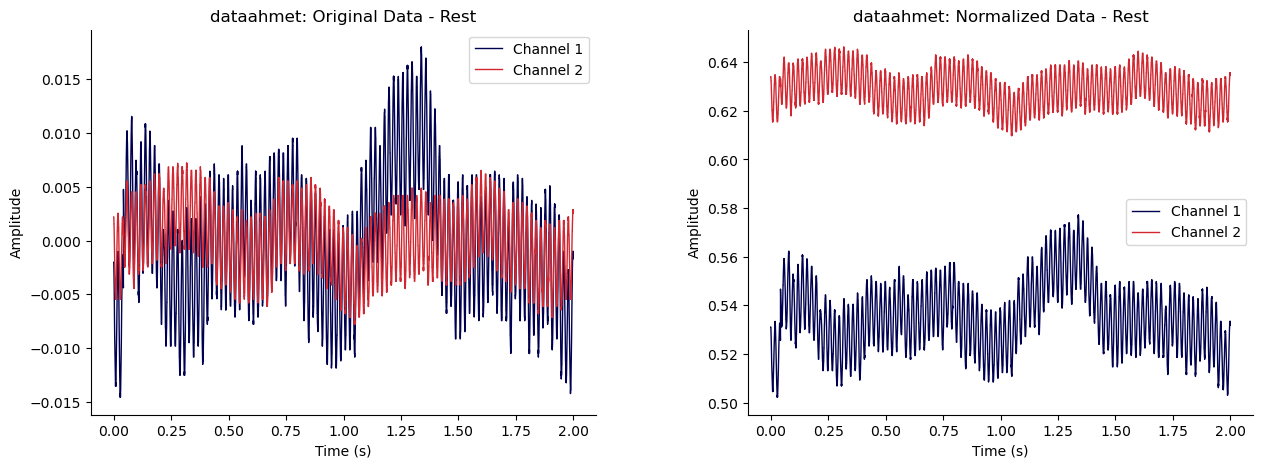

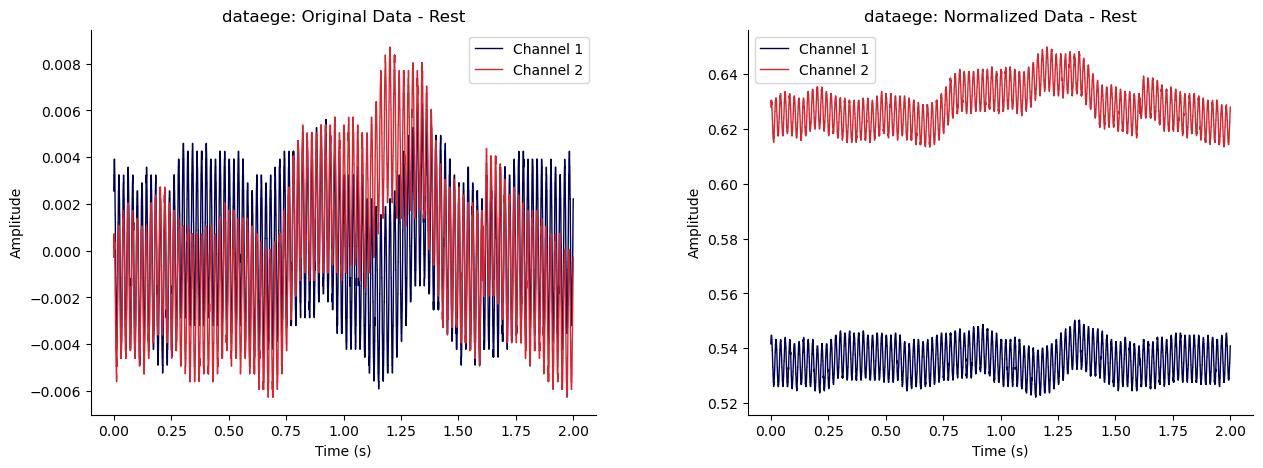

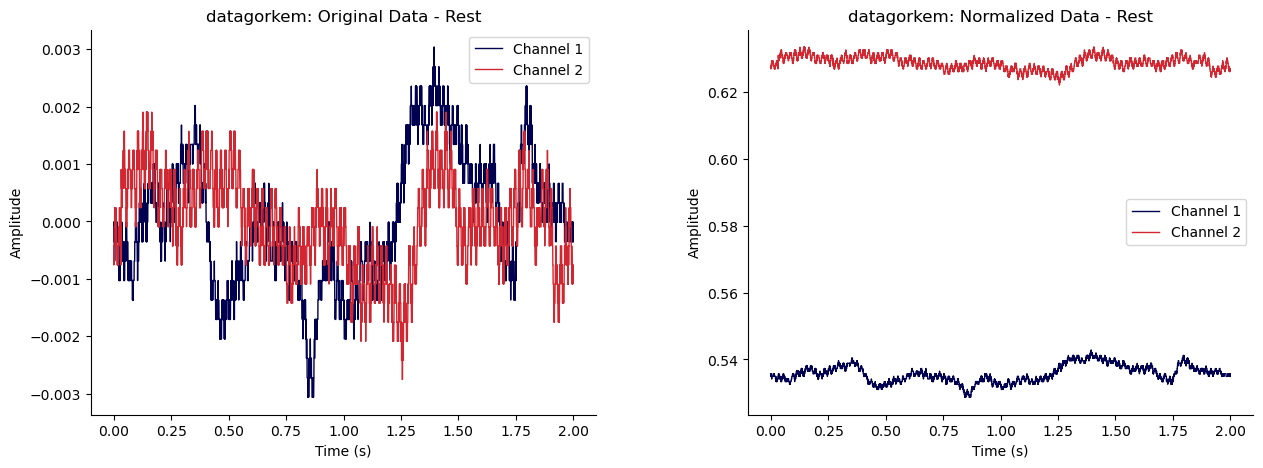

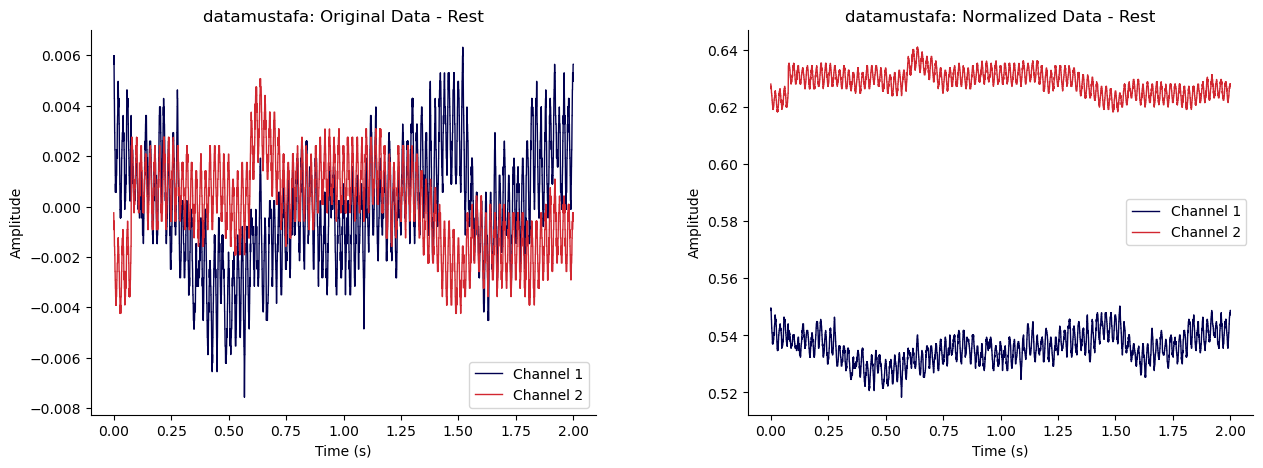

In [79]:
def plot_signal(df, gesture, participant, title, color=colors, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.plot(df['Time(s)'], df['Channel 1'], label='Channel 1', linewidth=1, color=color[0])
    ax.plot(df['Time(s)'], df['Channel 2'], label='Channel 2', linewidth=1, color=color[1])
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend()

    sns.despine(ax=ax)

# Define the list of participants
participants = ['dataahmet', 'dataege', 'datagorkem', 'datamustafa']

# Define the gesture to plot
selected_gesture = 'Rest'

# Loop through all participants and plot the original and normalized data for the selected gesture
for participant in participants:
    # Select the original data and the normalized data
    original_data = df_original[(df_original['GestureName'] == selected_gesture) & (df_original['ParticipantName'] == participant)]
    normalized_data = df_normalized[(df_normalized['GestureName'] == selected_gesture) & (df_normalized['ParticipantName'] == participant)]

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot the original data
    plot_signal(original_data, selected_gesture, participant,
                title=f'{participant}: Original Data - {selected_gesture}', ax=axes[0])

    # Plot the normalized data
    plot_signal(normalized_data, selected_gesture, participant,
                title=f'{participant}: Normalized Data - {selected_gesture}', ax=axes[1])

    # Adjust the space between the subplots
    plt.subplots_adjust(wspace=0.3)

    # Show the plots
    plt.show()


## Handling Outliers

In this block, we first prepared the data by dropping rows with NaN values in Channel 1 and Channel 2. We then applied various outlier handling and data transformation techniques to the df_normalized DataFrame. These techniques include:

Hampel Filter: We applied the Hampel filter to each channel, which is a robust outlier detection technique based on the median and the Median Absolute Deviation (MAD).

In [80]:
df_normalized.dropna(subset=['Channel 1', 'Channel 2'], inplace=True)


def hampel_filter(data, window_size=7, num_dev=3):
    new_data = data.reset_index(drop=True).values
    L = len(new_data)
    new_data = np.concatenate([new_data[window_size-1:0:-1], new_data, new_data[-2:-window_size-1:-1]])
    filtered_data = np.zeros_like(new_data)
    for i in range(L):
        idx = np.arange(i, i + window_size)
        x0 = np.median(new_data[idx])
        S0 = 1.4826 * np.median(np.abs(new_data[idx] - x0))
        if np.abs(new_data[idx[-1]] - x0) > num_dev * S0:
            filtered_data[i] = x0
        else:
            filtered_data[i] = new_data[idx[-1]]
    return filtered_data[window_size-1:-window_size+1]

def apply_hampel_filter(df):
    df['Channel 1'] = hampel_filter(df['Channel 1'])
    df['Channel 2'] = hampel_filter(df['Channel 2'])
    return df


df_hampel = apply_hampel_filter(df_normalized.copy())

In [81]:
df_hampel.head()

,Time(s),Channel 1,Channel 2,ParticipantName,GestureName
1,0.00000,0.560296,0.603683,dataahmet,Hand outward
2,0.00025,0.561075,0.604490,dataahmet,Hand outward
3,0.00050,0.562634,0.605297,dataahmet,Hand outward
4,0.00075,0.563414,0.606912,dataahmet,Hand outward
5,0.00100,0.564194,0.606912,dataahmet,Hand outward


## Power Spectrum Density for Each Gesture

Nyquist: 
Sampling rate = 1 / 0.00025 = 4000 samples per second


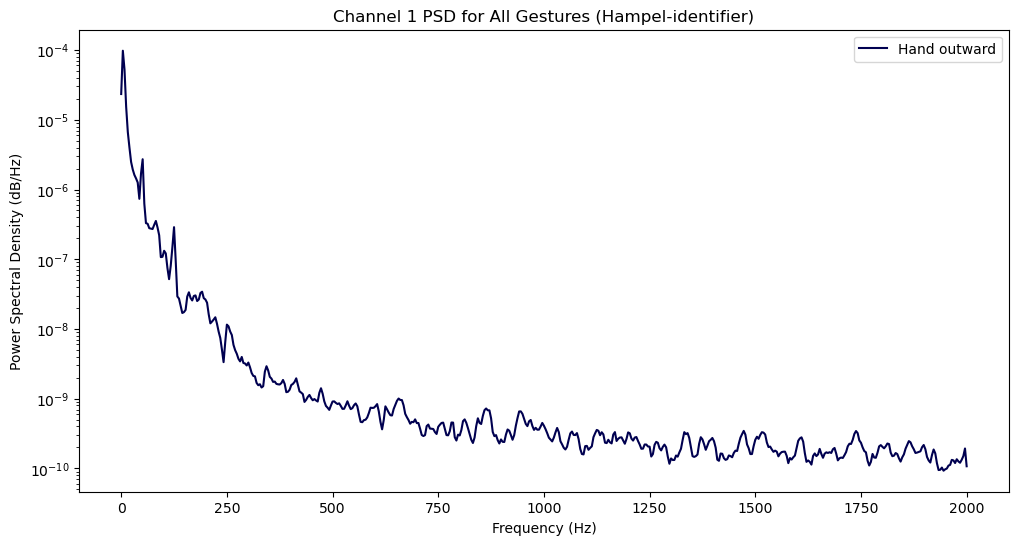

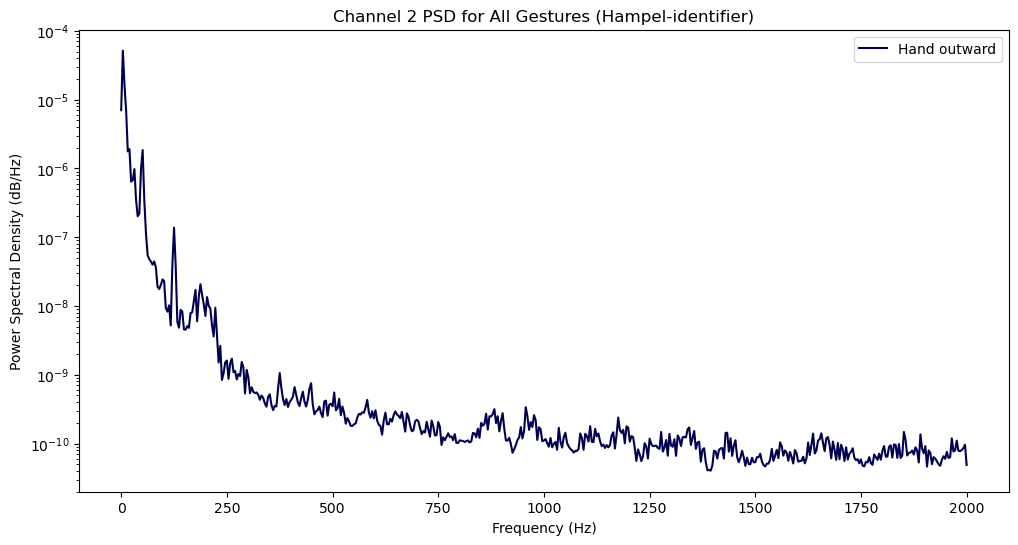

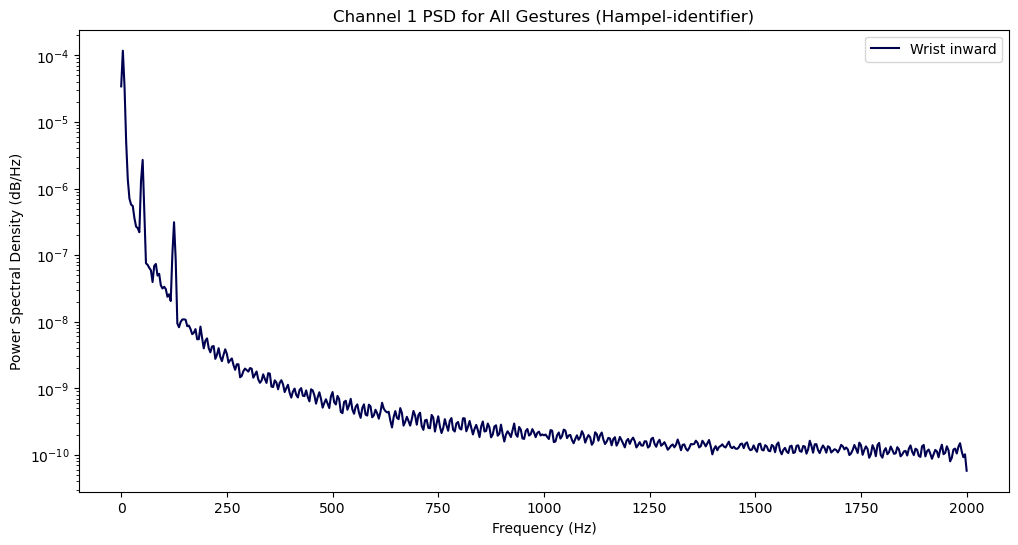

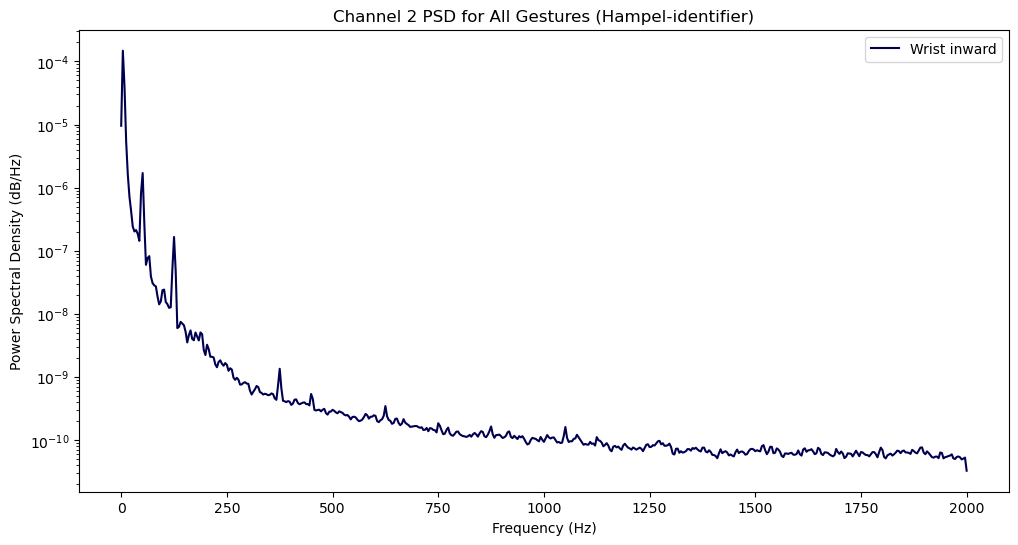

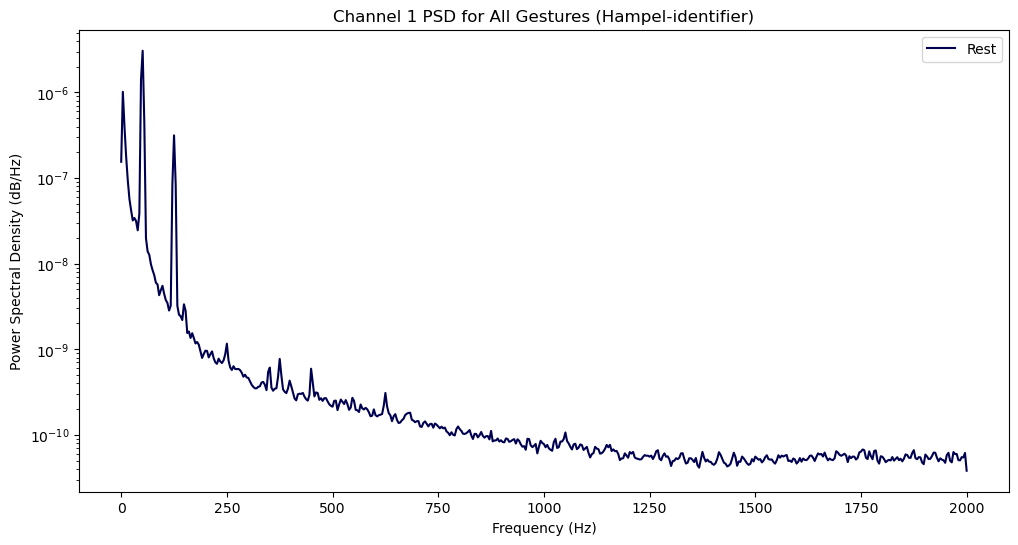

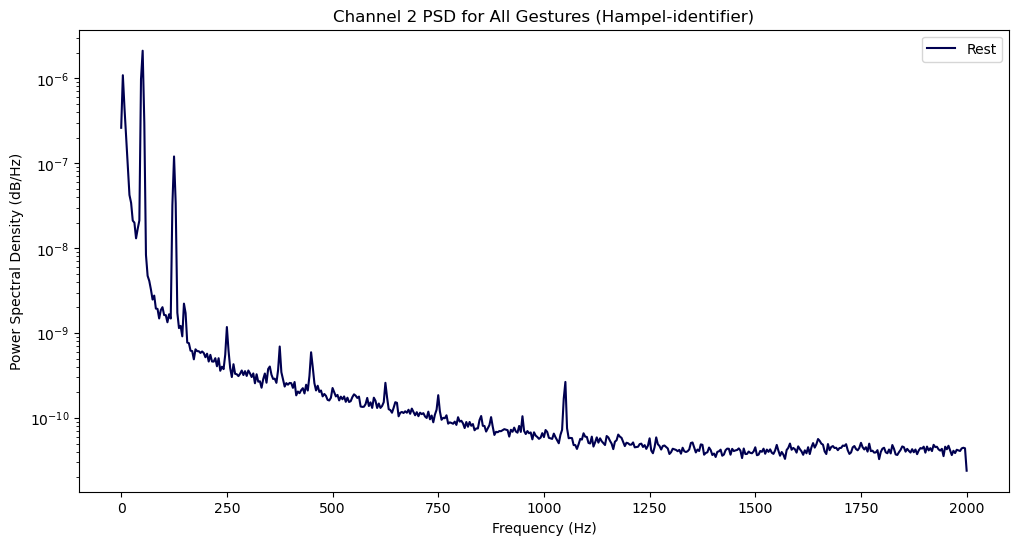

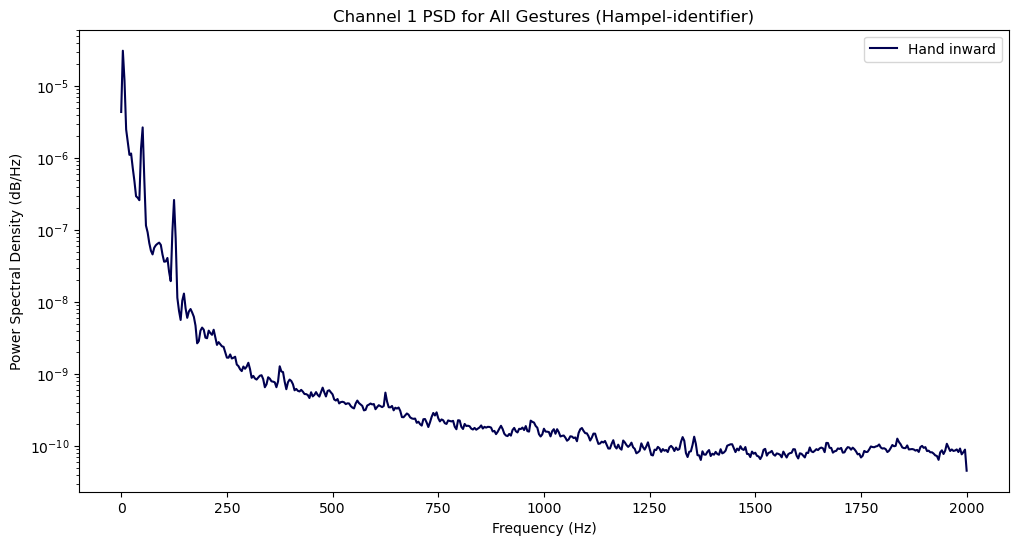

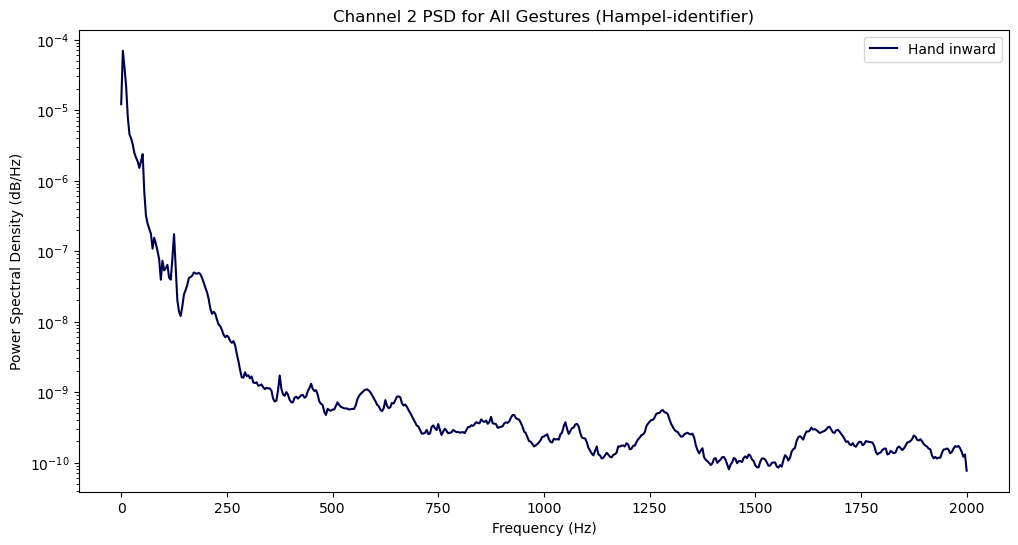

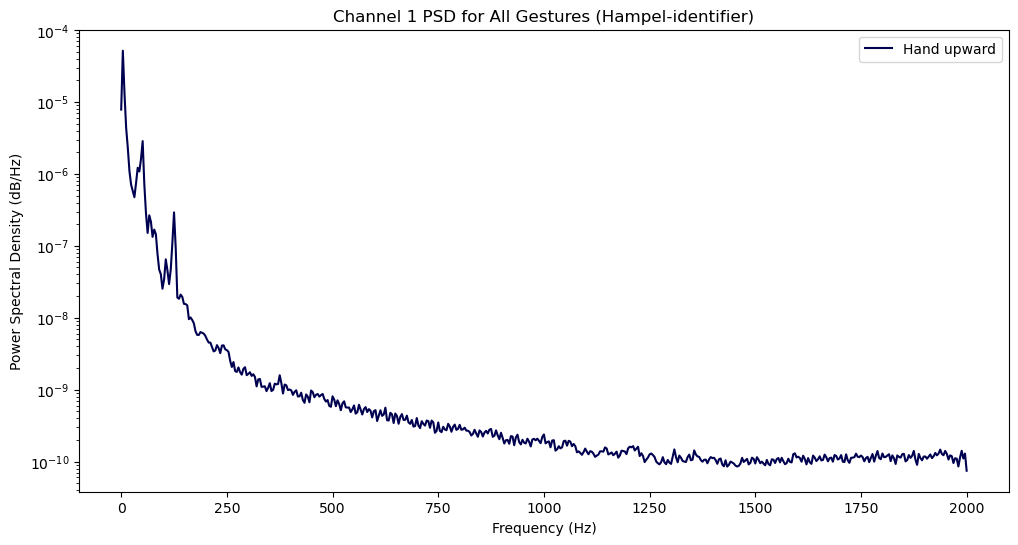

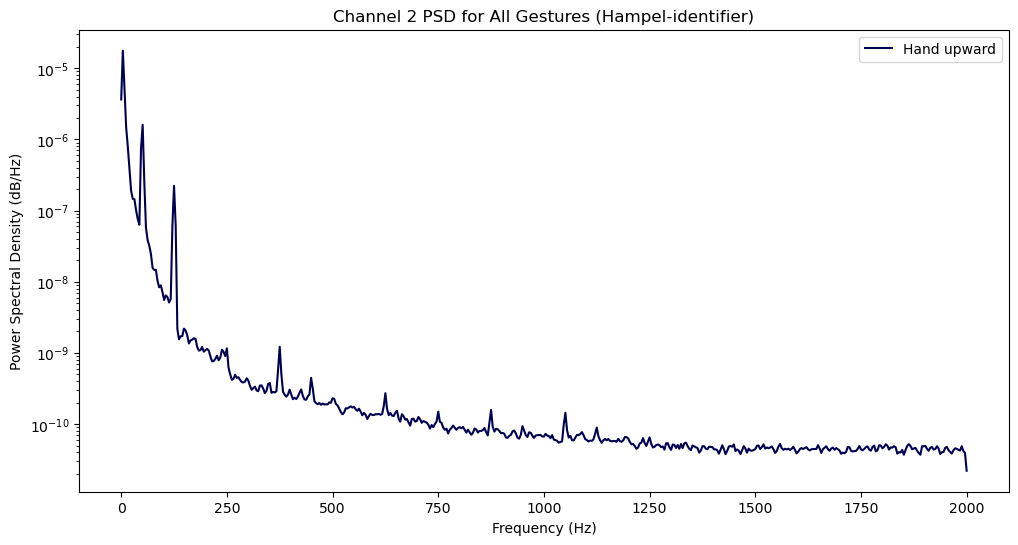

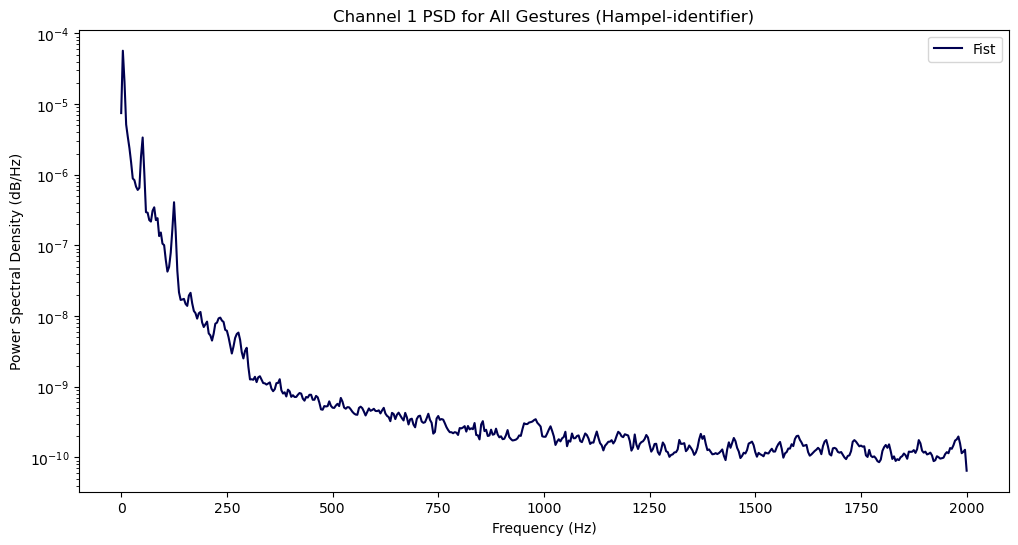

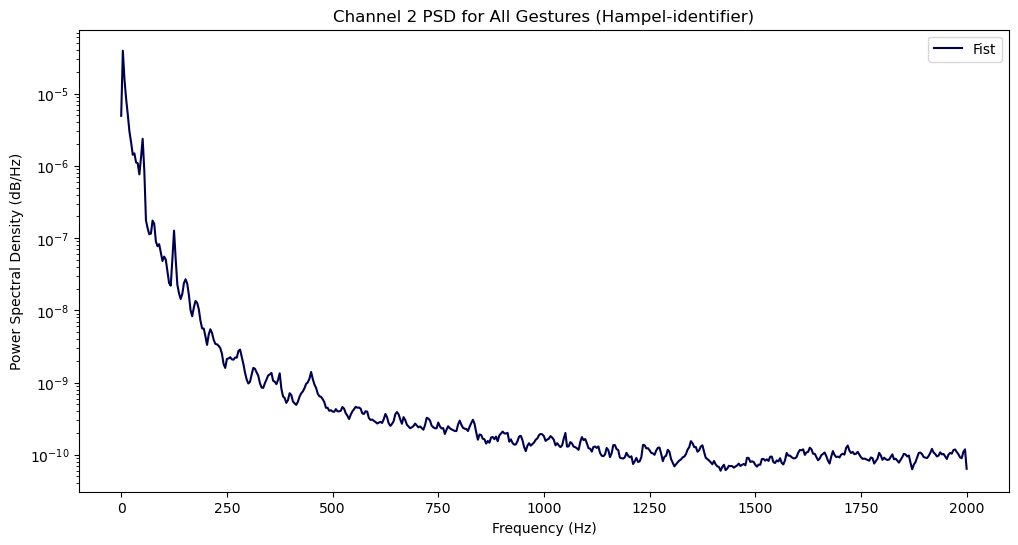

In [82]:
def plot_psd(df_filtered, channel, fs, preprocessing_method):
    plt.figure(figsize=(12, 6))
    
    for gesture in df_filtered['GestureName'].unique():
        gesture_df = df_filtered[df_filtered['GestureName'] == gesture]
        freqs, psd = welch(gesture_df[channel], fs, nperseg=1024)

        plt.semilogy(freqs, psd, label=gesture)
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title(f'{channel} PSD for All Gestures ({preprocessing_method})')
    plt.legend()
    plt.show()


fs = 4000 
gesture_names = df['GestureName'].unique()

#Plot the PSD for the Hampel-identifier dataframe
for gesture_name in gesture_names:
    df_filtered = df_hampel[df_hampel['GestureName'] == gesture_name]
    plot_psd(df_filtered, 'Channel 1', fs, 'Hampel-identifier')
    plot_psd(df_filtered, 'Channel 2', fs, 'Hampel-identifier')    

## Bandpass Filter

This section of the code defines the bandpass filter function and applies it to the sEMG data for each of the six preprocessed dataframes.

In [83]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

fs = 6000  # Set the sampling frequency
lowcut = 1  # Set the lower cutoff frequency
highcut = 200  # Set the upper cutoff frequency

for participant in df['ParticipantName'].unique():
    participant_df = df[df['ParticipantName'] == participant].copy()
    
    # Apply the filter to both channels
    participant_df['Filtered Channel 1'] = butter_bandpass_filter(participant_df['Channel 1'], lowcut, highcut, fs)
    participant_df['Filtered Channel 2'] = butter_bandpass_filter(participant_df['Channel 2'], lowcut, highcut, fs)

    df_temp = df.loc[participant_df.index].copy()
    df_temp['Filtered Channel 1'] = participant_df['Filtered Channel 1']
    df_temp['Filtered Channel 2'] = participant_df['Filtered Channel 2']
    
    df.loc[participant_df.index, 'Filtered Channel 1'] = df_temp['Filtered Channel 1']
    df.loc[participant_df.index, 'Filtered Channel 2'] = df_temp['Filtered Channel 2']

In [84]:
df_hampel_filtered = df_hampel.copy()
df_hampel_filtered['Filtered Channel 1'] = butter_bandpass_filter(df_hampel_filtered['Channel 1'], 1, 200, 5000)
df_hampel_filtered['Filtered Channel 2'] = butter_bandpass_filter(df_hampel_filtered['Channel 2'], 1, 200, 5000)

Channel 1: Hampel


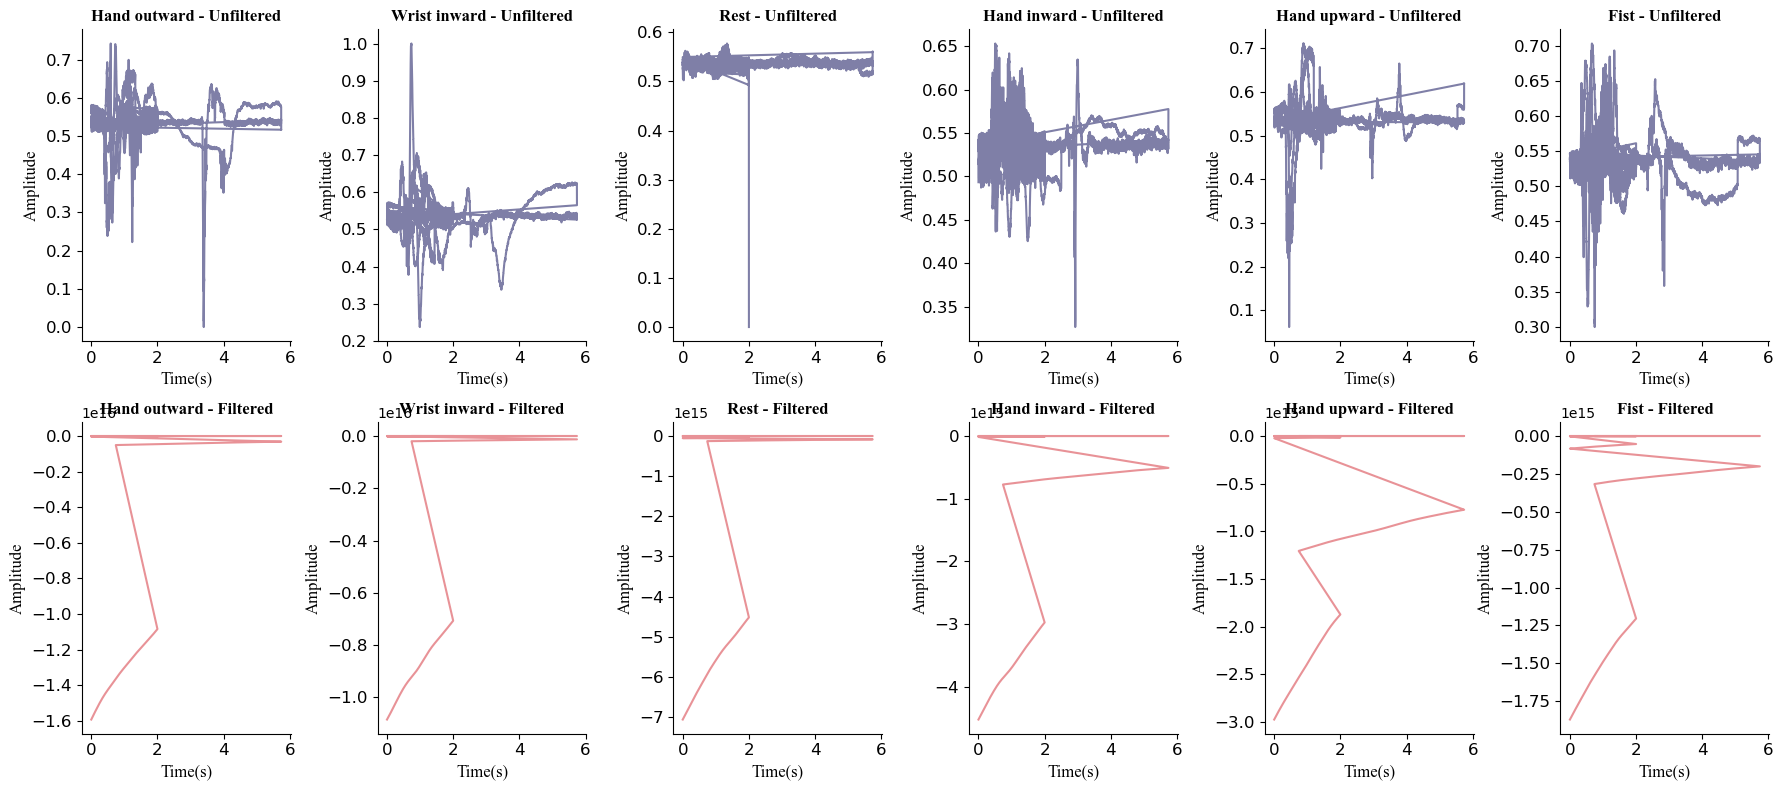

In [85]:
# Define a function to plot sEMG data
def plot_emg_data(df, title, ax, channel, color):
    
    for i, (_, group) in enumerate(df.groupby(['GestureName'])):
        ax.plot(group['Time(s)'], group[channel], color=color, alpha=0.5)
    ax.set_title(title, fontproperties=font_times_bold)
    ax.set_xlabel('Time(s)', fontproperties=font_times)
    ax.set_ylabel('Amplitude', fontproperties=font_times)
    ax.tick_params(axis='both', labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

# Set the channel to plot
channel = 'Channel 1'

# Plot the data before and after filtering
gesture_names = df_hampel['GestureName'].unique().tolist()
fig, axes = plt.subplots(nrows=2, ncols=len(gesture_names), figsize=(18, 8))

for i, gesture in enumerate(gesture_names):
    # Get the data for the participant
    gesture_unfiltered = df_hampel[(df_hampel['GestureName'] == gesture) &
                                       (df_hampel['GestureName'] == gesture)]
    gesture_filtered = df_hampel_filtered[(df_hampel_filtered['GestureName'] == gesture) &
                                     (df_hampel_filtered['GestureName'] == gesture)]

    # Plot the unfiltered data
    plot_emg_data(gesture_unfiltered, f'{gesture} - Unfiltered', axes[0, i], channel, colors[0])
    # Plot the filtered data
    plot_emg_data(gesture_filtered, f'{gesture} - Filtered', axes[1, i], 'Filtered Channel 1', colors[1])

fig.tight_layout()
print("Channel 1: Hampel")
plt.show()

## Windowing and Feature Extraction

In [98]:
def extract_features(windows, fs):
    # Calculate features for each window
    features = []
    for window in windows:
        # Calculate time-domain features
        mean = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        var = np.var(window, axis=0)

        # Calculate frequency-domain features
        freqs, psd = welch(window, fs, axis=0)
        peak_freq = freqs[np.argmax(psd)]

        # Combine features
        feature_vector = np.hstack([mean, std, var, peak_freq])

        features.append(feature_vector)

    return np.array(features)


def extract_windows_and_features(df, window_size, stride, fs):
    windows = []
    labels = []

    # Slide window across each gesture in the dataframe
    for gesture in df['GestureName'].unique():
        gesture_df = df[df['GestureName'] == gesture]

        # Apply sliding window to current gesture data
        for i in range(0, len(gesture_df) - window_size, stride):
            window = gesture_df[i:i + window_size]

            # Add window data and label to lists
            windows.append(window[['Filtered Channel 1', 'Filtered Channel 2']].values)
            labels.append(gesture)

    # Convert lists to NumPy arrays
    windows = np.array(windows)
    labels = np.array(labels)

    # Extract features from windows
    features = extract_features(windows, fs)

    return features, labels


fs = 4000  
window_size = 200
stride = 50  

## KNN

In [99]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

X_zscore, y_zscore = extract_windows_and_features(df_hampel_filtered, window_size, stride, fs)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_zscore)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)

# 10-fold cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(knn, X_scaled, y_zscore, cv=cv, scoring='accuracy')

# Print mean and standard deviation of accuracy scores
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))

# Get confusion matrix
y_pred = cross_val_predict(knn, X_scaled, y_zscore, cv=cv)
conf_matrix = confusion_matrix(y_zscore, y_pred)
print('Confusion matrix:\n', conf_matrix)

# Print classification report
print("\nClassification Report:\n", classification_report(y_zscore, y_pred))

/Users/mertbarbaros/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


Accuracy: 0.97 (+/- 0.01)
Confusion matrix:
 [[1673   24   12   17    2   28]
 [  23 1707    7   13    4    2]
 [  16   12 1860   24    2    2]
 [  22   26   32 1659    4   13]
 [   0    8    7    9 1732    0]
 [  27   10    2   20    0 1697]]

Classification Report:
               precision    recall  f1-score   support

        Fist       0.95      0.95      0.95      1756
 Hand inward       0.96      0.97      0.96      1756
Hand outward       0.97      0.97      0.97      1916
 Hand upward       0.95      0.94      0.95      1756
        Rest       0.99      0.99      0.99      1756
Wrist inward       0.97      0.97      0.97      1756

    accuracy                           0.97     10696
   macro avg       0.97      0.97      0.97     10696
weighted avg       0.97      0.97      0.97     10696



## Review

In the task of hand gesture recognition using surface electromyography (sEMG), the raw signal plays a crucial role. This signal represents the electrical activity produced by the muscles, which are captured by electrodes and can be used to identify different hand gestures. The figure above shows the raw signal from Channel 1 for the 'Fist' gesture. It can be observed that the signal varies over time, exhibiting different patterns that correspond to the muscle activity during this specific gesture.

The windowing process involves segmenting the continuous signal into smaller windows or frames. Each window consists of multiple samples collected over a certain period, with some overlap between consecutive windows to maintain continuity of the data. This is important to capture the temporal dynamics of the signal, as the muscle activities related to different gestures vary over time. The figure above demonstrates the windowing process for the 'Hand Inward' gesture on Channel 1. It can be seen that each window captures a portion of the signal, and these windows overlap to a certain degree.

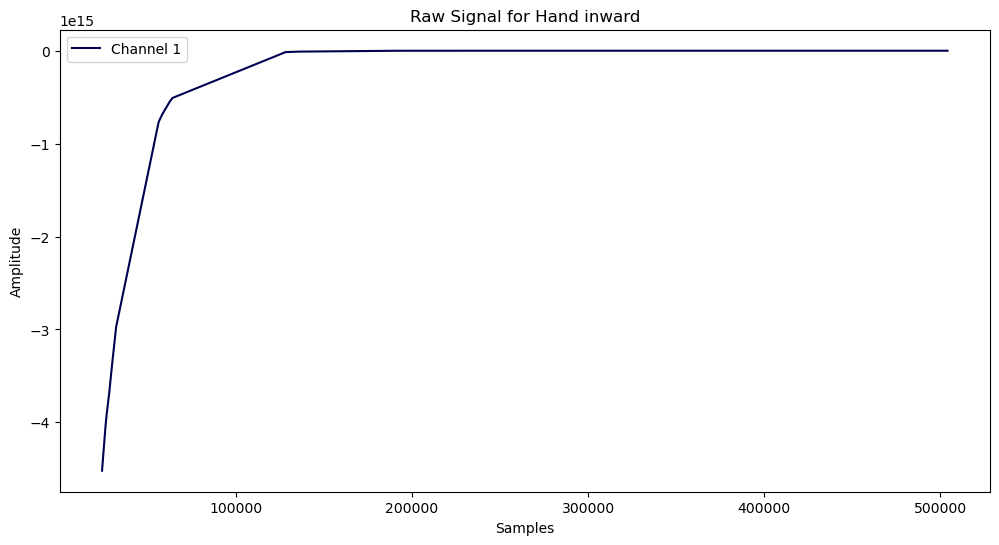

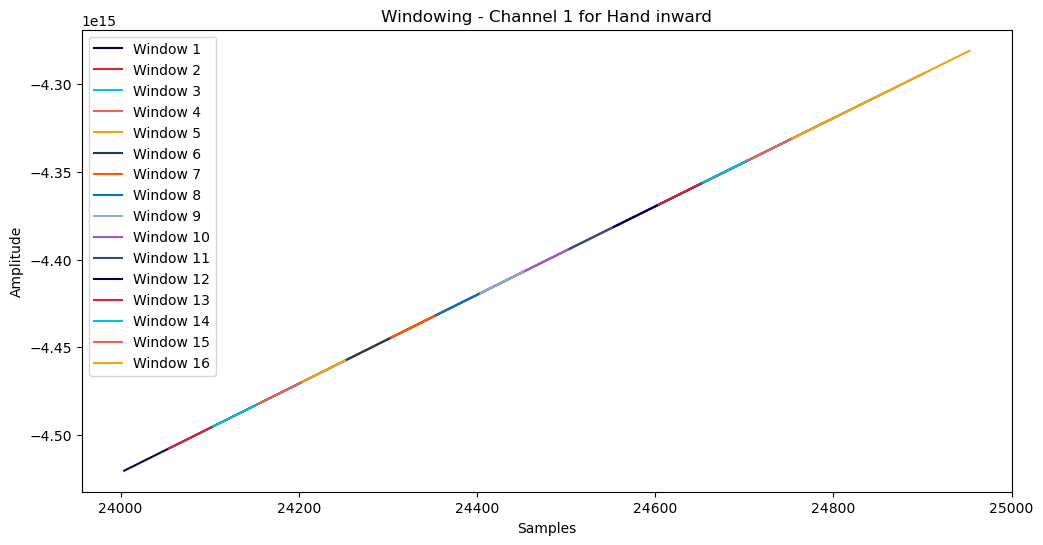

In [95]:
# Raw signal

gesture = 'Hand inward'  # change to any gesture you want to visualize
gesture_df = df_hampel_filtered[df_hampel_filtered['GestureName'] == gesture]

plt.figure(figsize=(12, 6))
plt.plot(gesture_df['Filtered Channel 1'], label='Channel 1')
plt.title('Raw Signal for ' + gesture)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))

# Plot the first few windows
for i in range(0, window_size*4, stride):
    window = gesture_df[i:i+window_size]
    ax.plot(window.index, window['Filtered Channel 1'], label=f'Window {i//stride+1}')

ax.set_title('Windowing - Channel 1 for ' + gesture)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()